In [10]:
import zipfile

In [9]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
import warning
warning.filterwarning("ignore")

ModuleNotFoundError: No module named 'tensorflow'

In [9]:
!ls


drive  sample_data


In [11]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/mini/insectimages1",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 298 files belonging to 1 classes.


In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras

In [13]:
from google.colab import drive


In [6]:
from google.colab import drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

folder_path = '/content/drive/MyDrive/mini/insectimages1/'
files = os.listdir(folder_path)

for file in files:
    print(file)


insectimages1


In [15]:
BATCH_SIZE=32
IMAGE_SIZE=256
image_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/mini/insectimages1",
  shuffle=True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE,
)
BATCH_SIZE=8

Found 298 files belonging to 1 classes.


In [16]:
import os
data_dir="/content/drive/MyDrive/mini/insectimages1"
print("number of samples in--")
for f in os.listdir(data_dir +'/'):
    if os.path.isdir(data_dir+'/'+f):
        print('\n'+f.upper())
        for fx in os.listdir(data_dir+'/'+f+'/'):
            print(fx,":",len(os.listdir(data_dir+'/'+f+'/'+fx+'/')))

number of samples in--

INSECTIMAGES1
testing : 10
training : 10
validation : 10


In [18]:
!ls "/content/drive/MyDrive/mini/insectimages1"


insectimages1


In [19]:
batch = 8
print("Train dataset:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/insectimages1/training',
    batch_size=batch
)
print("Validation dataset")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/insectimages1/validation',
    batch_size=batch
)
print("Test dataset")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/insectimages1/testing',
    batch_size=batch
)


Train dataset:
Found 213 files belonging to 10 classes.
Validation dataset
Found 40 files belonging to 10 classes.
Test dataset
Found 45 files belonging to 10 classes.


In [21]:
#looking into the class names
class_names=train_ds.class_names
print(class_names)

['acid_bugs', 'ants', 'bed_bugs', 'bee', 'chiggers', 'fleas', 'mosquitos', 'no_bites', 'spiders', 'ticks']


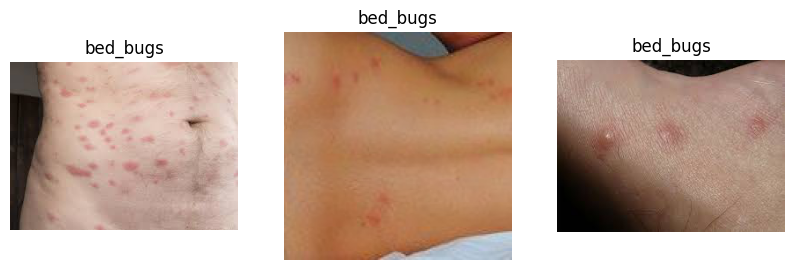

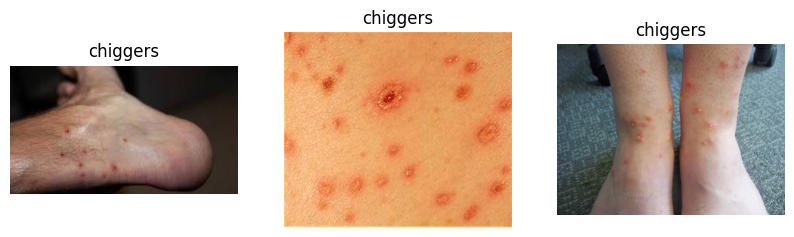

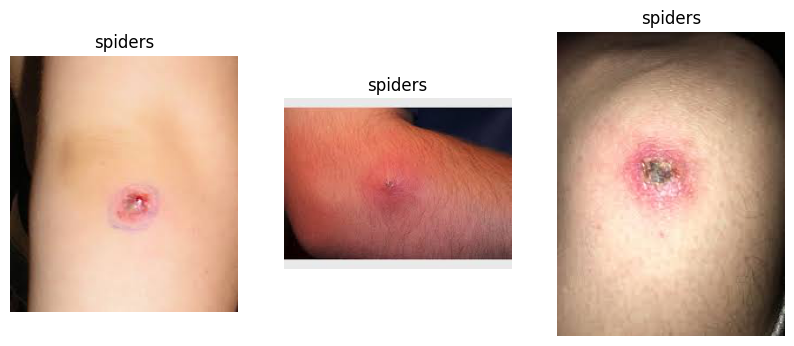

In [23]:
num_samples = 3
for x in class_names:
    plt.figure(figsize=(10, 10))
    class_directory = os.path.join(data_dir, 'insectimages1', 'training', x)
    filenames = os.listdir(class_directory)
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(os.path.join(class_directory, filenames[i]))
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")


In [24]:
#preprocessing
#looking into the shape of the batches and individual samples
#set the input shape
print(" into the shape of images and lables in one batch\n")

for image_batch,labels_batch in train_ds:
    input_shape=image_batch[0].shape
    print("shape of the imges input for one batch:",image_batch.shape)
    print("shape of the images labels for one batch:",labels_batch.shape)
    break

 into the shape of images and lables in one batch

shape of the imges input for one batch: (8, 256, 256, 3)
shape of the images labels for one batch: (8,)


In [25]:
#Normalization the pixel values
normalization_layer=layers.experimental.preprocessing.Rescaling(1./255)

train_ds=train_ds.map(lambda x,y:(normalization_layer(x), y))
val_ds=val_ds.map(lambda x,y:(normalization_layer(x), y))
test_ds=test_ds.map(lambda x,y:(normalization_layer(x), y))

In [26]:
#Augmenting images in the train set to increase dataset size

data_augmentation=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomRotation((-0.1,0.1))
    ])

print("train size(number of batches) before augmnetation:",len(train_ds))

#apply only to tain set
aug_ds=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y))

print("size (number of batches) of augmented dataset:",len(aug_ds))

#adding to train_ds
train_ds=train_ds.concatenate(aug_ds)

print("train size (number of batches) after augmentation:",len(train_ds))

train size(number of batches) before augmnetation: 27
size (number of batches) of augmented dataset: 27
train size (number of batches) after augmentation: 54


In [27]:
#THE MODEL
base_model=tensorflow.keras.applications.VGG16(weights="imagenet",input_shape=input_shape,include_top=False)

base_model.trainable=False

inputs=tensorflow.keras.Input(shape=input_shape)

x=base_model(inputs,training=False)
x=tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs=tensorflow.keras.layers.Dense(len(class_names),activation="softmax")(x)

model=tensorflow.keras.Model(inputs,outputs)

cb=[EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)]
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(0.01) ,metrics=['accuracy'])

history1 = model.fit(train_ds, validation_data = val_ds,epochs=32,callbacks=cb)

Epoch 1/32
54/54 [==============================] - 345s 6s/step - loss: 2.3652 - accuracy: 0.1714 - val_loss: 2.3735 - val_accuracy: 0.1750
Epoch 2/32
54/54 [==============================] - 327s 6s/step - loss: 1.9818 - accuracy: 0.2840 - val_loss: 2.2606 - val_accuracy: 0.1500
Epoch 3/32
54/54 [==============================] - 341s 6s/step - loss: 1.8270 - accuracy: 0.3779 - val_loss: 2.1707 - val_accuracy: 0.2500
Epoch 4/32
54/54 [==============================] - 342s 6s/step - loss: 1.7558 - accuracy: 0.3991 - val_loss: 2.1920 - val_accuracy: 0.1750
Epoch 5/32
54/54 [==============================] - 328s 6s/step - loss: 1.7029 - accuracy: 0.4038 - val_loss: 2.1825 - val_accuracy: 0.3000
Epoch 6/32
54/54 [==============================] - 339s 6s/step - loss: 1.6588 - accuracy: 0.4131 - val_loss: 2.2276 - val_accuracy: 0.2750
Epoch 7/32
54/54 [==============================] - 331s 6s/step - loss: 1.5147 - accuracy: 0.4742 - val_loss: 2.1462 - val_accuracy: 0.2750
Epoch 8/32
54

In [30]:
model.compile(loss=SparseCategoricalCrossentropy(),optimizer=Adam(0.001),metrics=['accuracy'])

history2=model.fit(train_ds,validation_data=val_ds,epochs=32,callbacks=cb)

Epoch 1/32
54/54 [==============================] - 356s 7s/step - loss: 1.3802 - accuracy: 0.5728 - val_loss: 2.0817 - val_accuracy: 0.3250
Epoch 2/32
54/54 [==============================] - 356s 7s/step - loss: 1.3420 - accuracy: 0.6127 - val_loss: 2.0842 - val_accuracy: 0.3000
Epoch 3/32
54/54 [==============================] - 350s 7s/step - loss: 1.3408 - accuracy: 0.6127 - val_loss: 2.0779 - val_accuracy: 0.3250
Epoch 4/32
54/54 [==============================] - 350s 7s/step - loss: 1.3277 - accuracy: 0.6103 - val_loss: 2.0875 - val_accuracy: 0.3000
Epoch 5/32
54/54 [==============================] - 353s 7s/step - loss: 1.3371 - accuracy: 0.6150 - val_loss: 2.0861 - val_accuracy: 0.3000
Epoch 6/32
54/54 [==============================] - 332s 6s/step - loss: 1.2980 - accuracy: 0.6221 - val_loss: 2.0791 - val_accuracy: 0.3000
Epoch 7/32
54/54 [==============================] - 348s 6s/step - loss: 1.2906 - accuracy: 0.6268 - val_loss: 2.0763 - val_accuracy: 0.3000
Epoch 8/32
54

In [31]:
model.evaluate(test_ds)

6/6 [==============================] - 39s 6s/step - loss: 1.6215 - accuracy: 0.5333


[1.6214855909347534, 0.5333333611488342]

In [32]:
#plotting the metrics
def plot(history1,history2,variable1,variable2):
    #combining metrics from both trainings
    var1_history=history1[variable1]
    var1_history.extend(history2[variable2])

    var2_history=history1[variable2]
    var2_history.extend(history2[variable2])

    #plotting them
    plt.plot(range(len(var1_history)),var1_history)
    plt.plot(range(len(var2_history)),var2_history)
    plt.legend([variable1,variable2])
    plt.title(variable1)

In [33]:
plot(history1.history,history2.history,"accuracy","val_accuracy")

In [34]:
plot(history1.history,history2.history,"loss",'val_loss')

In [35]:
#prediction
#prediction for all samples in the dataset

plt.figure(figsize=(10,10))

for i in test_ds.as_numpy_iterator():
    img,label= i
    for x in range(len(label)):
        ax = plt.subplot(1, len(label),x + 1)
        plt.axis('off')
        plt.imshow(img[x])
        output=model.predict(np.expand_dims(img[x],0))
        pred=np.argmax(output[0])
        t="prdicted:"+ class_names[pred]
        t=t+"\nTrue:"+ class_names[label[x]]
        t=t+"\nProbability:"+ str(output[0][pred])
        plt.title(t)

1/1 [==============================] - 1s 659ms/step


1/1 [==============================] - 1s 1s/step


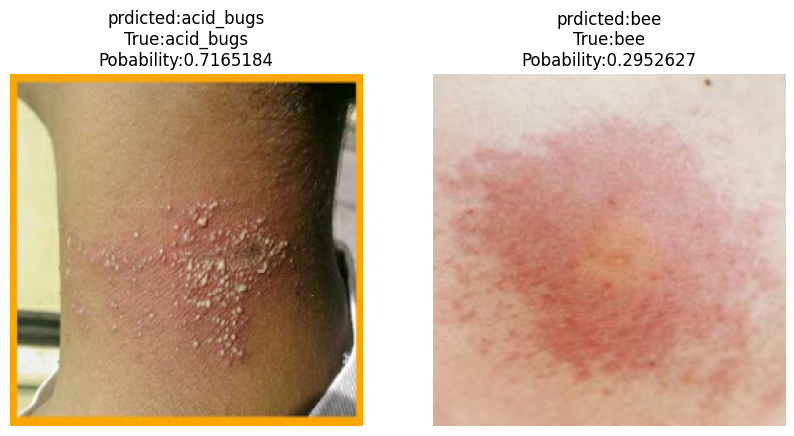

In [36]:
samples=2
plt.figure(figsize=(10,10))
for i in test_ds.as_numpy_iterator():
  img,
  for x in range(samples):
    ax=plt.subplot(1,samples,x+1)
    plt.axis('off')
    plt.imshow(img[x])
    output=model.predict(np.expand_dims(img[x],0))
    pred=np.argmax(output[0])
    t="prdicted:"+ class_names[pred]
    t=t+"\nTrue:"+ class_names[label[x]]
    t=t+"\nPobability:"+ str(output[0][pred])
    plt.title(t)